In [1]:
# Author Anthony Colton

import torch
import torch.nn as nn
import torch.nn.functional as F

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

CUDA is available!  Training on GPU ...


# Helper functions

In [2]:
# HELPER FUNCTIONS

import random
import torchvision.models as models
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def load_data(path, label, images, labels):
    # Loop through the normal images and append them to the images list with a label of 0
    for filename in os.listdir(path):
        if filename.endswith(".jpeg"):
            img = Image.open(os.path.join(path, filename))
            images.append(img)
            labels.append(label)

def get_data(normal_path, pnumonia_path):
    images = []
    labels = []
    
    load_data(normal_path, 0, images, labels)
    load_data(pnumonia_path, 1, images, labels)
    
    return images, labels


def shuffle_data(images, labels):
    # Shuffle the images and labels in the same order
    zipped_data = list(zip(images, labels))
    random.shuffle(zipped_data)
    images, labels = zip(*zipped_data)
    return images, labels


def get_model_resnet18(dropout = 0):
    # Load the ResNet-18 model
    resnet18 = models.resnet18(pretrained=True)

    # modify input layer to accept grayscale images and add dropout
    resnet18.conv1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #,nn.Dropout2d(p=0.1)
    )

    # Add dropout between each hidden layer except for the output layer
    num_classes = 2  # replace with the number of classes in your task
    resnet18.fc = nn.Sequential(
        nn.Linear(resnet18.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, num_classes),
    )

    return resnet18.to(device)

"""def get_model_mobilenetv2(dropout=0):
    # Load the MobileNetV2 model
    mobilenetv2 = models.mobilenet_v2(pretrained=True)

    # Modify input layer to accept grayscale images and add dropout
    mobilenetv2.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

    # Add dropout to the classifier
    num_classes = 2  # Replace with the number of classes in your task
    mobilenetv2.classifier[1] = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(mobilenetv2.last_channel, num_classes),
    )

    return mobilenetv2.to(device)"""

# Added Batch normalization together with dropout to combat overfitting
def get_model_mobilenetv2(dropout=0):
    # Load the MobileNetV2 model
    mobilenetv2 = models.mobilenet_v2(pretrained=True)

    # Modify input layer to accept grayscale images
    mobilenetv2.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

    # Add batch normalization to the features
    for module in mobilenetv2.features.modules():
        if isinstance(module, nn.Conv2d):
            module = nn.Sequential(module, nn.BatchNorm2d(module.out_channels))

    # Add dropout to the classifier
    num_classes = 2  # Replace with the number of classes in your task
    mobilenetv2.classifier[1] = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(mobilenetv2.last_channel, num_classes),
    )

    return mobilenetv2.to(device)


# Transforms to apply to all images
transform = transforms.Compose([
    transforms.Resize((240, 240)),  # resize to a fixed size
    transforms.CenterCrop((224, 224)),  # crop the center of the image
    transforms.Grayscale(num_output_channels=1),  # convert the image to grayscale
    transforms.ToTensor()  # convert images to PyTorch tensors
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

# Transforms to apply to aguemented images
augment_transforms = transforms.Compose([
    transforms.Resize((240, 240)),  # resize to a fixed size
    transforms.RandomRotation(4),  # randomly rotate the image by up to 5 degrees
    transforms.CenterCrop((224, 224)), # crop the center of the image
    #transforms.RandomHorizontalFlip(),  # randomly flip the image horizontally
    #transforms.RandomVerticalFlip(),  # randomly flip the image vertically
    #transforms.ColorJitter(brightness=0.05, contrast=0.05),  # add random brightness and contrast change
    transforms.Grayscale(num_output_channels=1),  # convert the image to grayscale
    transforms.ToTensor()  # convert images to PyTorch tensors
])

def apply_transforms(imgs_to_transform):
    # apply the transforms to each image in the list
    images_transformed = []
    for img in imgs_to_transform:
        images_transformed.append(transform(img))
    return images_transformed

def apply_augment_transforms(imgs_to_transform):
    # apply the transforms to each image in the list
    images_transformed = []
    for img in imgs_to_transform:
        images_transformed.append(transform(img))
    return images_transformed

def plot_epoch_accuracy(accuracy_list):
    num_epochs = len(accuracy_list[0])
    num_folds = len(accuracy_list)

    # Initialize list to store accuracy for each epoch
    epoch_accuracy_list = [[] for i in range(num_epochs)]

    # Populate list with accuracy for each epoch
    for fold, fold_accuracy in enumerate(accuracy_list):
        for epoch, accuracy in enumerate(fold_accuracy):
            epoch_accuracy_list[epoch].append((fold+1, accuracy))

    # Plot accuracy for each epoch
    for epoch, epoch_accuracy in enumerate(epoch_accuracy_list):
        if epoch_accuracy:
            folds, accuracy = zip(*epoch_accuracy)
            #folds, accuracy = zip(*[(f.cpu().numpy(), a.cpu().numpy()) for f, a in epoch_accuracy])
            plt.plot(folds, accuracy, label='Epoch {}'.format(epoch+1))

    # Set axis labels and legend
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Load the data into sets

In [3]:
# LOAD THE DATA INTO SETS

# Define the paths to the image files
train_normal_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
train_pneumonia_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'
val_normal_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/'
val_pneumonia_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/'

# Create empty lists to store the images and their labels
train_images = []
train_labels = []
#val_images = []
#val_labels = []

train_images, train_labels = get_data(train_normal_path, train_pneumonia_path)
#val_images, val_labels = get_data(val_normal_path, val_pneumonia_path)

print("train size: ", len(train_images))

train size:  5216


# Transforms for preprocessing the images

In [4]:
# TRANSFORMS FOR PREPROCESSING THE IMAGES

# apply the transforms to each image in the list
augmnent_normal_images = train_images[:1341]
augmnent_normal_labels = train_labels[:1341]

train_images = apply_augment_transforms(train_images)

train_images += apply_augment_transforms(augmnent_normal_images)
train_labels += augmnent_normal_labels

# Shuffle the images and labels in the same order
train_images, train_labels = shuffle_data(train_images, train_labels)

# Train the models

In [5]:
from sklearn.model_selection import KFold
import torch.optim as optim

def train_model_cross_val(dropout, dataset, criterion, num_epochs, batch_size, learning_rate=0.0001, num_folds=5, chosen_model="resnet18"):
    # Check if CUDA is available, otherwise use CPU.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Split dataset into folds.
    kf = KFold(n_splits=num_folds)
    fold = 0

    # Initialize best model and accuracy
    best_model = None
    best_acc = 0.0

    # Keeping track of best models
    best_epoch_models = []
    best_epoch_accuracy = [] 
    best_epoch_times_per_fold = []
    
    for i in range(num_epochs):
        best_epoch_models.append(None)
        best_epoch_accuracy.append(0)
        best_epoch_times_per_fold.append(0)
        
    # Saving accuracy for plot
    accuracy_list = []
    for i in range(num_folds):
        accuracy_list.append([])
    
    # Iterate over the folds.
    for train_indices, val_indices in kf.split(dataset):
        if chosen_model == "resnet18":
            model = get_model_resnet18(dropout)
        elif chosen_model == "mobilenetv2":
            model = get_model_mobilenetv2(dropout)
        elif chosen_model == "model_detect_pneumonia":
            model = model_detect_pneumonia
        
        #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)

        # Initialize train and validation loaders.
        train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
        val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
                    
        # Best validation accuracy this 
        best_val_acc = 0
        best_epoch = 0
        
        # Iterate over the dataset for each epoch.
        for epoch in range(num_epochs):

            # Set model to training mode.
            model.train()

            # Initialize training loss, number of correct predictions, and total number of samples.
            train_loss_sum = 0.0
            train_corrects = 0
            train_total = 0

            # Iterate over the training set.
            for inputs, labels in train_loader:

                # Move inputs and labels to device.
                inputs, labels = inputs.to(device), labels.to(device)

                # Reset optimizer gradients.
                optimizer.zero_grad()

                # Calculate model outputs, loss, and predictions.
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    loss.backward()
                    optimizer.step()

                # Update training loss, number of correct predictions, and total number of samples.
                train_loss_sum += loss.item() * inputs.size(0)
                train_total += labels.size(0)
                train_corrects += torch.sum(preds == labels.data)

            # Calculate training loss and accuracy.
            train_loss = train_loss_sum / train_total
            train_acc = train_corrects.double() / train_total

            # Initialize validation loss, number of correct predictions, and total number of samples.
            val_loss_sum = 0.0
            val_corrects = 0
            val_total = 0

            # Set model to evaluation mode.
            model.eval()

            # Iterate over the validation set.
            with torch.set_grad_enabled(False):
                for inputs, labels in val_loader:

                    # Move inputs and labels to device.
                    inputs, labels = inputs.to(device), labels.to(device)

                    # Calculate model outputs, loss, and predictions.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Update validation loss, number of correct predictions, and total number of samples.
                    val_loss_sum += loss.item() * inputs.size(0)
                    val_total += labels.size(0)
                    val_corrects += torch.sum(preds == labels.data)

            # Calculate validation loss and accuracy.
            val_loss = val_loss_sum / val_total
            val_acc = val_corrects.double() / val_total
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch
            
            if val_acc > best_epoch_accuracy[epoch]:
                best_epoch_models[epoch] = model
                best_epoch_accuracy[epoch] = val_acc
            
            """if epoch >= 3 and val_acc > best_epoch_accuracy[epoch]:
                best_epoch_models[epoch] = model
                best_epoch_accuracy[epoch] = val_acc"""


            # Print epoch and accuracy
            print('Epoch [{}/{}], Fold [{}/{}], Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch+1, num_epochs, fold+1, num_folds, train_acc, val_acc))
            
            # Append accuracy for this epoch and fold to list
            accuracy_list[fold].append(val_acc)

        # Print training and validation accuracy for current fold.
        print('Fold {}/{}: Best epoch: {} | Best validation Accuracy: {:.4f}'.format(fold+1, num_folds, best_epoch+1, best_val_acc))

        # Update the best epoch
        best_epoch_times_per_fold[best_epoch] += 1

        # Increment fold counter.
        fold += 1

        # Clear CUDA cache to avoid out of memory errors.
        torch.cuda.empty_cache()

    
    # Find the best model by averaging the epochs across the folds.
    epoch_averages = [] # index = epoch
    for i in range(len(accuracy_list[0])):
        epoch_averages.append(0)
    
    for i in range(len(accuracy_list)):
        for j in range(len(accuracy_list[i])):
            epoch_averages[j] += accuracy_list[i][j]
    
    #epoch_everages_res = []
    for i in range(len(epoch_averages)):
        epoch_averages[i] = (epoch_averages[i] / len(accuracy_list[0]))
    
    """if (np.array(best_epoch_times_per_fold).argmax()) <= 3:
        best_model = best_epoch_models[-1].clone()
    else:
        best_model = best_epoch_models[np.array(best_epoch_times_per_fold).argmax()].clone()"""
    best_model = best_epoch_models[np.array(best_epoch_times_per_fold).argmax()]
    #best_model = best_epoch_models[np.array(best_epoch_times_per_fold).argmax()].clone()
    
    print()
    print("Returning the model which performs best over all folds")
    print("Best epoch (based on highest average): ", torch.tensor(epoch_averages).cpu().numpy().argmax() + 1)
    
    # Plot 
    plot_epoch_accuracy(torch.tensor(accuracy_list).cpu().tolist())
    
    # Delete variables
    del best_epoch_models
    del best_epoch_accuracy
    del best_epoch_times_per_fold
    
    # Return best model.
    return best_model


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Training the model to detect pneumonia

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.4MB/s]


Epoch [1/4], Fold [1/5], Training Accuracy: 0.9432, Validation Accuracy: 0.9733
Epoch [2/4], Fold [1/5], Training Accuracy: 0.9901, Validation Accuracy: 0.9893
Epoch [3/4], Fold [1/5], Training Accuracy: 0.9975, Validation Accuracy: 0.9962
Epoch [4/4], Fold [1/5], Training Accuracy: 0.9979, Validation Accuracy: 0.9931
Fold 1/5: Best epoch: 3 | Best validation Accuracy: 0.9962
Epoch [1/4], Fold [2/5], Training Accuracy: 0.9457, Validation Accuracy: 0.9817
Epoch [2/4], Fold [2/5], Training Accuracy: 0.9893, Validation Accuracy: 0.9809
Epoch [3/4], Fold [2/5], Training Accuracy: 0.9958, Validation Accuracy: 0.9878
Epoch [4/4], Fold [2/5], Training Accuracy: 0.9985, Validation Accuracy: 0.9863
Fold 2/5: Best epoch: 3 | Best validation Accuracy: 0.9878
Epoch [1/4], Fold [3/5], Training Accuracy: 0.9485, Validation Accuracy: 0.9771
Epoch [2/4], Fold [3/5], Training Accuracy: 0.9907, Validation Accuracy: 0.9893
Epoch [3/4], Fold [3/5], Training Accuracy: 0.9937, Validation Accuracy: 0.9893
Ep

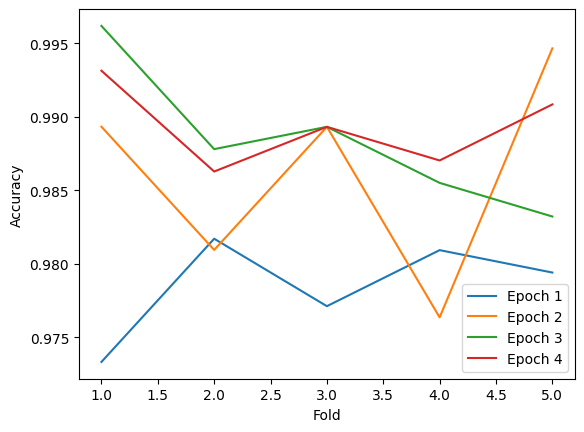

In [6]:
# TRAINING THE MODEL 

import torch.optim as optim

num_epochs = 5
learning_rate_SGD = 0.01
learning_rate_adam = 0.0001
batch_size = 50
momentum = 0.9 # to update learning rate during training for SGD optimizer
dropout = 0.75
num_folds = 5

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Create a PyTorch DataLoader for the training and validation sets
train_dataset = torch.utils.data.TensorDataset(torch.stack(train_images), torch.tensor(train_labels))

#model_detect_pneumonia = train_model_cross_val(dropout, train_dataset, criterion, num_epochs, batch_size, learning_rate_adam, num_folds, "mobilenetv2")
model_detect_pneumonia = train_model_cross_val(dropout, train_dataset, criterion, num_epochs, batch_size, learning_rate_adam, num_folds)

In [7]:
# Clear data for space

del train_images
del train_labels
"""del val_images
del val_labels"""
del train_dataset
#del val_dataset

# PART 2: 

# Get pneumonia dataset

In [8]:
# GET DATA

train_pneumonia_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'

# Normal = 1341
# bacteria = 2530
# Virus = 1345

images = []
labels = []

images_bac = []
labels_bac = []

images_vir = []
labels_vir = []

for filename in os.listdir(train_pneumonia_path):
    splited = filename.split('_')
    if splited[1] == "virus":
        img = Image.open(os.path.join(train_pneumonia_path, filename))
        images_vir.append(img)
        labels_vir.append(0)
    elif splited[1] == "bacteria":
        img = Image.open(os.path.join(train_pneumonia_path, filename))
        images_bac.append(img)
        labels_bac.append(1)

# apply the transforms to each image in the list
augmnent_vir_images = images_vir[:1185]
augmnent_vir_labels = labels_vir[:1185]


#images = apply_transforms(images_vir) + apply_transforms(images_bac)
images = apply_augment_transforms(images_vir) + apply_augment_transforms(images_bac)
labels = labels_vir + labels_bac

images += apply_augment_transforms(augmnent_vir_images)
labels += augmnent_vir_labels

# Shuffle the images and labels in the same order
images, labels = shuffle_data(images, labels)

print("pn_images_bac size: ", len(images_bac))
print("pn_images_vir size: ", len(images_vir) + len(augmnent_vir_images))
print()
print("pn_image size: ", len(images))
print("pn_labels size: ", len(labels))

del augmnent_vir_images
del augmnent_vir_labels
del images_bac
del images_vir
del labels_bac
del labels_vir

pn_images_bac size:  2530
pn_images_vir size:  2530

pn_image size:  5060
pn_labels size:  5060


# Train the model to detect what type of pneumonia

In [9]:
num_epochs = 5
learning_rate_SGD = 0.01
learning_rate_adam = 0.0001
batch_size = 50
momentum = 0.9 # to update learning rate during training for SGD optimizer
dropout = 0.5
num_folds = 5

criterion = nn.CrossEntropyLoss()

# Create dataset for training
dataset = torch.utils.data.TensorDataset(torch.stack(images), torch.tensor(labels))

# Train the model
model_detect_type_pneumonia = train_model_cross_val(dropout, dataset, criterion, num_epochs, batch_size, learning_rate_adam, num_folds, "mobilenetv2")

In [10]:
# CLEAR VARIABLES FOR SPACE
del images
del labels
del dataset

# Function to test each model seperately

In [11]:
# TEST THE MODEL

def test_model(model, test_loader, criterion):
    
    # Check if CUDA is available, otherwise use CPU.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize test loss, number of correct predictions, and total number of samples.
    test_loss_sum = 0.0
    test_corrects = 0
    test_total = 0

    # Set model to evaluation mode.
    model.eval()
    
    # Iterate over the test set.
    with torch.set_grad_enabled(False):
        for inputs, labels in test_loader:
            
            # Move inputs and labels to device.
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Calculate model outputs, loss, and predictions.
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            # Update test loss, number of correct predictions, and total number of samples.
            test_loss_sum += loss.item() * inputs.size(0)
            test_total += labels.size(0)
            test_corrects += torch.sum(preds == labels.data)

    # Calculate test loss and accuracy.
    test_loss = test_loss_sum / test_total
    test_acc = test_corrects.double() / test_total

    # Print performance metrics.
    print('Test Loss: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_acc))
    
    return test_loss, test_acc

# Delete variables to reduce space

# Function to test both models combined

In [12]:
def test_models(images, labels_has_pneumonia, labels_type_of_pneumonia, model_detect_pneumonia, model_type_pneumonia):

    test_corrects = 0
    test_total = 0
    for i in range(len(images)):
        test_total += 1
        
        # Pass image through the first network
        model_detect_pneumonia.eval() # Set network to evaluation mode
        with torch.no_grad():
            output1 = model_detect_pneumonia(images[i].unsqueeze(0).to(device))
        
        # Check if model predicted correctly
        _, pred1 = torch.max(output1, 1)
        if pred1.item() != labels_has_pneumonia[i]: # If predicted wrongly
            continue
        elif pred1.item() == 0: # If predicted correct and it is not pneumonia
            test_corrects += 1
            continue
            
        # it will continue if predicted correct and pneumonia is predicted

        # Pass image through the second network
        model_type_pneumonia.eval() # Set network to evaluation mode
        with torch.no_grad():
            output2 = model_type_pneumonia(images[i].unsqueeze(0).to(device))

        # Check if the second network predicts correcty
        _, pred2 = torch.max(output2, 1)
        if pred2.item() != labels_type_of_pneumonia[i]: # If predicted wrongly
            continue
            
        # Predictions went well!
        test_corrects += 1
        
    # Calculate validation loss and accuracy.
    #test_loss = val_loss_sum / val_total
    test_acc = float(test_corrects) / test_total

    # Print epoch and accuracy
    print('Test Accuracy: {:.4}'.format(test_acc))
     
    return test_acc

# Get the test data and process it

In [13]:
# GET TEST DATA

test_normal_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/'
test_pneumonia_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

test_images = []
test_labels_has_pn = []
test_labels_type_pn = []

test_images_pn = []

# LOAD PNUMONIA DATASET AND SAVE LABELS

for filename in os.listdir(test_pneumonia_path):
    splited = filename.split('_')
    if splited[1] == "virus":
        img = Image.open(os.path.join(test_pneumonia_path, filename))
        test_images.append(img)
        test_images_pn.append(img)
        test_labels_has_pn.append(1)
        test_labels_type_pn.append(0)
    elif splited[1] == "bacteria":
        img = Image.open(os.path.join(test_pneumonia_path, filename))
        test_images.append(img)
        test_images_pn.append(img)
        test_labels_has_pn.append(1)
        test_labels_type_pn.append(1)

# LOAD NORMAL DATASET AND LABELS
for filename in os.listdir(test_normal_path):
    if filename.endswith(".jpeg"):
        img = Image.open(os.path.join(test_normal_path, filename))
        test_images.append(img)
        test_labels_has_pn.append(0)       
        
# apply the transforms to each image in the list
test_images_transformed = []
for i in range(len(test_images_pn)):
    test_images_transformed.append(transform(test_images_pn[i]))
test_images_pn = test_images_transformed

test_images_pn_transformed = []
for i in range(len(test_images)):
    test_images_pn_transformed.append(transform(test_images[i]))
test_images = test_images_pn_transformed

print("test_image size: ", len(test_images))
print("test_labels_has_pn size: ", len(test_labels_has_pn))
print("test_labels_type_pn size: ", len(test_labels_type_pn))

test_image size:  624
test_labels_has_pn size:  624
test_labels_type_pn size:  390


# Test each model seperately

In [14]:
# Create a PyTorch DataLoader for the training and validation sets
test_has_pneumonia_dataset = torch.utils.data.TensorDataset(torch.stack(test_images), torch.tensor(test_labels_has_pn))
test_has_pneumonia_loader = torch.utils.data.DataLoader(test_has_pneumonia_dataset, batch_size=50, shuffle=False)
test_model(model_detect_pneumonia, test_has_pneumonia_loader, criterion)

del test_has_pneumonia_dataset
del test_has_pneumonia_loader

test_type_pneumonia_dataset = torch.utils.data.TensorDataset(torch.stack(test_images_pn), torch.tensor(test_labels_type_pn))
test_type_pneumonia_loader = torch.utils.data.DataLoader(test_type_pneumonia_dataset, batch_size=50, shuffle=False)
test_model(model_detect_type_pneumonia, test_type_pneumonia_loader, criterion)

del test_type_pneumonia_dataset
del test_type_pneumonia_loader

Test Loss: 0.8761, Test Acc: 0.7997


NameError: name 'model_detect_type_pneumonia' is not defined

# Test both models combined

In [ ]:
# TEST THE MODELS

test_models(test_images, test_labels_has_pn, test_labels_type_pn, model_detect_pneumonia, model_detect_type_pneumonia)